# Visualisation of recordings, too long/too short; to figure out what is going on

In this notebook you find two approaches to visualize the parquet files of sign recordings.

## Import of libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

dir = '/data/asl-signs'

Code for visualization was adapted from https://www.kaggle.com/code/danielpeshkov/animated-data-visualization

## Import of train csv file

In [2]:
#import csv file with train targets
train_df = pd.read_csv('../data/asl-signs/train.csv')

## Example sequences with frame length more than 100 frames:
These sequences were extracted from the EDA_DataCleaning Notebook


sequence_id - Frame length
* 203327050     106
* 269920128     129
* 621161958     139
* 690456887     132
* 994309330     134
* 1862716737    135
* 2085945934    133
* 2292927765    114
* 2779257484    123
* 2889201858    129
* 3116562701    118
* 3380869090    116
* 3797899944    123
* 4183154128    125

## Defining sequence id and extracting sequence information

In [3]:
train_df.query(f'sign == "grandpa"').sample(5)

,path,participant_id,sequence_id,sign
51634,train_landmark_files/2044/3113664567.parquet,2044,3113664567,grandpa
87486,train_landmark_files/16069/708312812.parquet,16069,708312812,grandpa
52991,train_landmark_files/37055/3167398073.parquet,37055,3167398073,grandpa
66346,train_landmark_files/25571/3719404884.parquet,25571,3719404884,grandpa
43047,train_landmark_files/37055/2759832323.parquet,37055,2759832323,grandpa


In [4]:
# If you want to check specific signs or specific participants you can get example sequences 
# enter participant or sign you want to check, enter 0 if all should be queried
participant = 55372 
label_sign = 'grandpa'

# getting samples for desired sign and/or participant
if participant == 0:
    # get sequences for specific sign
    display(train_df.query(f'sign == "{label_sign}"').sample(5))
else:
    if label_sign == 0:
        # get sequences for specific participant
        display(train_df.query(f'participant_id == {participant}').sample(5))
    else:
        display(train_df.query(f'sign == "{label_sign}" and participant_id == {participant}').sample(5))

,path,participant_id,sequence_id,sign
88735,train_landmark_files/55372/760885242.parquet,55372,760885242,grandpa
12373,train_landmark_files/55372/1509324276.parquet,55372,1509324276,grandpa
19320,train_landmark_files/55372/179699576.parquet,55372,179699576,grandpa
51528,train_landmark_files/55372/3108752892.parquet,55372,3108752892,grandpa
28631,train_landmark_files/55372/2179175517.parquet,55372,2179175517,grandpa


In [5]:
# copy a sequence id from the query above or
# enter a specific sequence you want to check
sequence = 3902738690  

In [6]:
## Loading the corresponding parquet file
path_to_sign = train_df.query(f'sequence_id == {sequence}').iloc[0, 0]
sign = pd.read_parquet(f'..{dir}/{path_to_sign}')
sign.y = sign.y * -1

#print information about the selected sequence
print(f'The sign shown in the sequence is: {train_df.query(f"sequence_id == {sequence}").iloc[0,3]}.')
print(f'The sign was recorded by participant: {train_df.query(f"sequence_id == {sequence}").iloc[0,1]}.')
print(f'Shape of the selected recording is: {sign.shape}')
print(f'The frame length is: {sign.frame.max() - sign.frame.min()} frames.')

The sign shown in the sequence is: grandpa.
The sign was recorded by participant: 32319.
Shape of the selected recording is: (29322, 7)
The frame length is: 53 frames.


--------

## First approach of visualization

These two functions return the coordinate values with connecting lines for hands and pose.

In [7]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

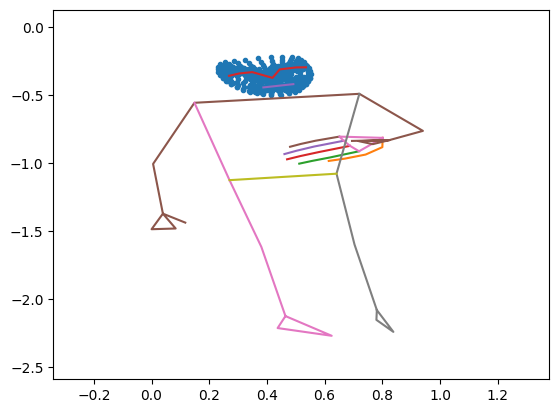

In [8]:
#run function to plot selected sequence
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())

--------
## Second approach for visualisation - Animation

Code for animation was adapted from: https://www.kaggle.com/code/ted0071/gislr-visualization/notebook 

## Import of libraries

In [9]:
!pip install -q flatbuffers 2> /dev/null
!pip install -q mediapipe 2> /dev/null

In [10]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt

from matplotlib import animation
from pathlib import Path
import IPython
from IPython import display as ds
from IPython.display import HTML

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

objc[16336]: Class CaptureDelegate is implemented in both /Users/franzi/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x169fb25a0) and /Users/franzi/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x15f430860). One of the two will be used. Which one is undefined.
objc[16336]: Class CVWindow is implemented in both /Users/franzi/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x169fb25f0) and /Users/franzi/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x15c2a4a68). One of the two will be used. Which one is undefined.
objc[16336]: Class CVView is implemented in both /Users/franzi/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x169fb2618) and /Users/franzi/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packa

In [11]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

## Functions for visualisation

In [12]:
class Cfg:
    RANDOM_STATE = 2023
    INPUT_ROOT = Path('../data/asl-signs/')
    OUTPUT_ROOT = Path('../images/working')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'

In [13]:
def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_landmark_data_by_id(sequence_id, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_df.query(f'sequence_id == {sequence}').iloc[0, 0] # changed, check
    return read_landmark_data_by_path(file_path)

In [14]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

In [15]:
height = 1600
width = 1200

data = sign
frame_id = data['frame'][0]

In [16]:
def create_blank_image(height, width):
    return np.zeros((height, width, 3), np.uint8)

def draw_landmarks(
    data, 
    image, 
    frame_id, 
    landmark_type, 
    connection_type, 
    landmark_color=(255, 0, 0), 
    connection_color=(0, 20, 255), 
    thickness=1, 
    circle_radius=1
):
    """Draws landmarks"""
    df = data.groupby(['frame', 'type']).get_group((frame_id, landmark_type))
    landmarks = [landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for idx, lm in df.iterrows()]
    landmark_list = landmark_pb2.NormalizedLandmarkList(landmark = landmarks)

    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmark_list, 
        connections=connection_type,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=landmark_color, 
            thickness=thickness, 
            circle_radius=circle_radius),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=connection_color, 
            thickness=thickness, 
            circle_radius=circle_radius))
    return image

def draw_left_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='left_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
        connection_color=(0, 20, 255), 
        thickness=3, 
        circle_radius=3)

def draw_right_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='right_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
        connection_color=(0, 20, 255),
        thickness=3, 
        circle_radius=3)

def draw_face(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='face', 
        connection_type=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_color=(255, 255, 255),
        connection_color=(0, 255, 0))      
    
def draw_pose(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='pose', 
        connection_type=mp_pose.POSE_CONNECTIONS,
        landmark_color=(255, 255, 255),
        connection_color=(255, 0, 0),
        thickness=2, 
        circle_radius=2)

def create_frame(data, frame_id, height=1000, width=1000):
    image = create_blank_image(height, width)    

    draw_pose(data, image, frame_id) 
    draw_left_hand(data, image, frame_id)    
    draw_right_hand(data, image, frame_id)  
    draw_face(data, image, frame_id)
     
    return image

In [17]:
def create_frames(sequence_id, train_data, height=800, width=800):
    data = read_landmark_data_by_id(sequence_id, train_data)
    frame_ids = data['frame'].unique()
    images = [create_frame(data, frame_id=fid, height=height, width=width) for fid in frame_ids]
    return np.array(images)

In [18]:
def create_animation(images, fig, ax):
    ax.axis('off')
    
    ims = []
    for img in images:
        im = ax.imshow(img, animated=True)
        ims.append([im])
    
    func_animation = animation.ArtistAnimation(
        fig, 
        ims, 
        interval=100, 
        blit=True,
        repeat_delay=1000)

    return func_animation

def play_animation(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)    
    video = anim.to_html5_video()
    
    html = ds.HTML(video)
    ds.display(html)
    plt.close()

## Create Animation

In [19]:
play_animation(sequence, train_df, height=height, width=width)